# Klassifiziere Trainieren und Testen

TODO:
- [x] Load all images from "data/augment/"
- [x] Split into training and evaluation
- [x] Train 
- [x] Evaluate and print
    - [x] Confusion Matrix 
    - [x] Train Loss Function 
    - [x] Train Accuracy 
- [ ] Link Tutorial on transfer learning
- [ ] Write better prints 
- [x] Remove unused imports
- [ ] Kommentare ausschreiben

In [13]:
import numpy as np
import os

from keras.layers import Dense
from keras import Model
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications.mobilenet_v2 import decode_predictions

from keras import metrics
from keras.callbacks import Callback
from scikitplot.metrics import plot_confusion_matrix, plot_roc

import imageio.v2 as imageio 
from skimage.transform import resize

import matplotlib.pyplot as plt


# Bilder Laden


In [2]:
IMG_WIDTH   = 224
IMG_HEIGHT  = 224

IMGS_FOLDER = 'data/augment/'

train_data       = []
train_class_name = []
test_data        = []
test_class_name  = []

for img_dir in os.listdir(IMGS_FOLDER):
    img_index = 0
    for file_dir in os.listdir(os.path.join(IMGS_FOLDER, img_dir)):
        # Laden und vorbereiten des Bildes
        image_path = os.path.join(IMGS_FOLDER, img_dir,  file_dir)
        im = imageio.imread(image_path)
        im = preprocess_input(im)
        im = resize(im, output_shape=(IMG_WIDTH, IMG_HEIGHT))

        # Teilen in Training und Testing
        if (img_index % 3) != 0:
            train_data.append(im)
            train_class_name.append(img_dir)
        else:
            test_data.append(im)
            test_class_name.append(img_dir)

        img_index += 1

train_data = np.array(train_data)
test_data = np.array(test_data)

# print(train_data.shape)
# print(test_data.shape)

# Trainieren

In [19]:
# NOTE: Diese Callback-Klasse wurde dem Keras Metrics Tutorial von Neptune.ai (https://neptune.ai/blog/keras-metrics) entnommen. Die Methode on_epoch_end erzeugt nach jeder
#       durchlaufenen Epoche eine Confusion Matrix und eine ROC-Curve für jede Klasse im Datensatz. 

class PerformanceVisualizationCallback(Callback):
    def __init__(self, model, validation_data, image_dir):
        super().__init__()
        self.model = model
        self.validation_data = validation_data

        os.makedirs(image_dir, exist_ok=True)
        self.image_dir = image_dir

    def on_epoch_end(self, epoch, logs={}):
        y_pred = np.asarray(self.model.predict(self.validation_data[0]))
        y_true = self.validation_data[1]
        y_pred_class = np.argmax(y_pred, axis=1)

        fig, ax = plt.subplots(figsize=(16, 12))
        plot_confusion_matrix(y_true, y_pred_class, ax=ax)
        fig.set_frameon(True)
        fig.set_facecolor('white')
        fig.savefig(os.path.join(self.image_dir, f'conf_mat_epoch_{epoch}'), bbox_inches='tight', transparent=False)

        fig, ax = plt.subplots(figsize=(16, 12))
        plot_roc(y_true, y_pred, ax=ax)
        fig.set_frameon(True)
        fig.set_facecolor('white')
        fig.savefig(os.path.join(self.image_dir, f'roc_curve_epoch_{epoch}'), bbox_inches='tight', transparent=False)

Epoch 1/2
23/23 [==============================] - 10s 409ms/step
45/45 - 42s - loss: 1.9633 - accuracy: 0.5035 - val_loss: 0.9489 - val_accuracy: 0.8362 - 42s/epoch - 927ms/step
Epoch 2/2
23/23 [==============================] - 10s 416ms/step
45/45 - 39s - loss: 0.5770 - accuracy: 0.9456 - val_loss: 0.4568 - val_accuracy: 0.9492 - 39s/epoch - 875ms/step


C:\Users\Christian\AppData\Local\Temp\ipykernel_16512\3121287232.py:66: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


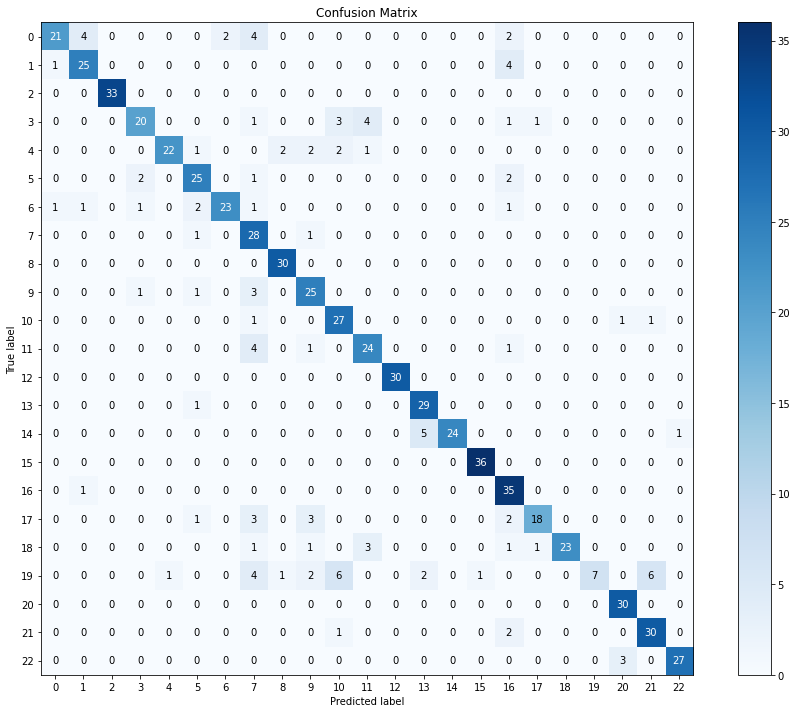

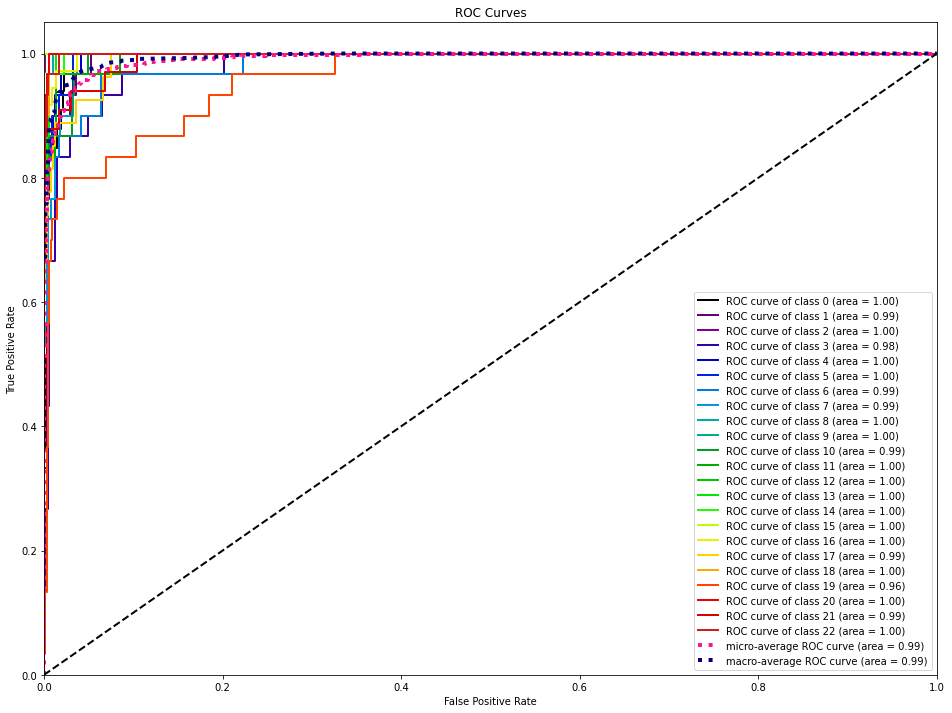

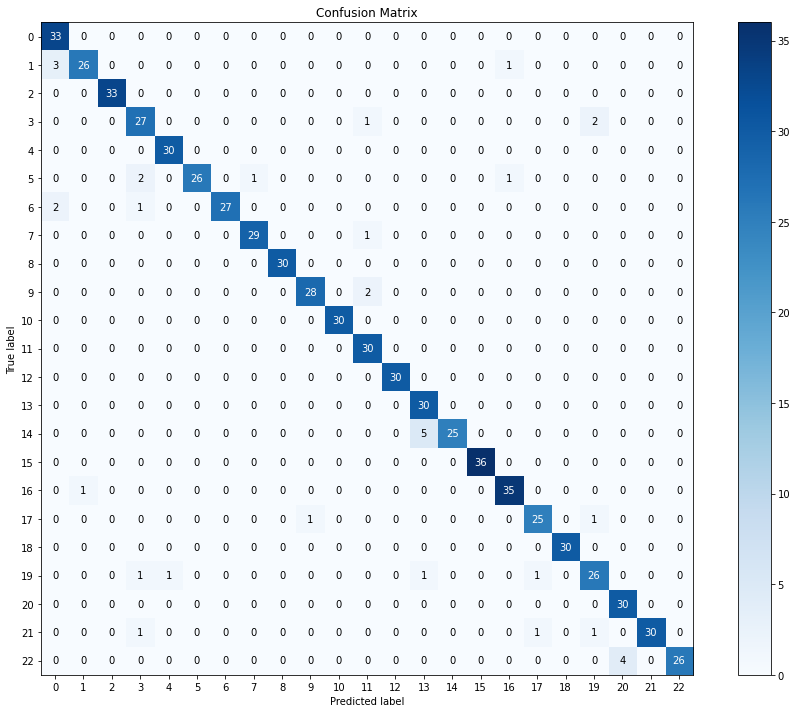

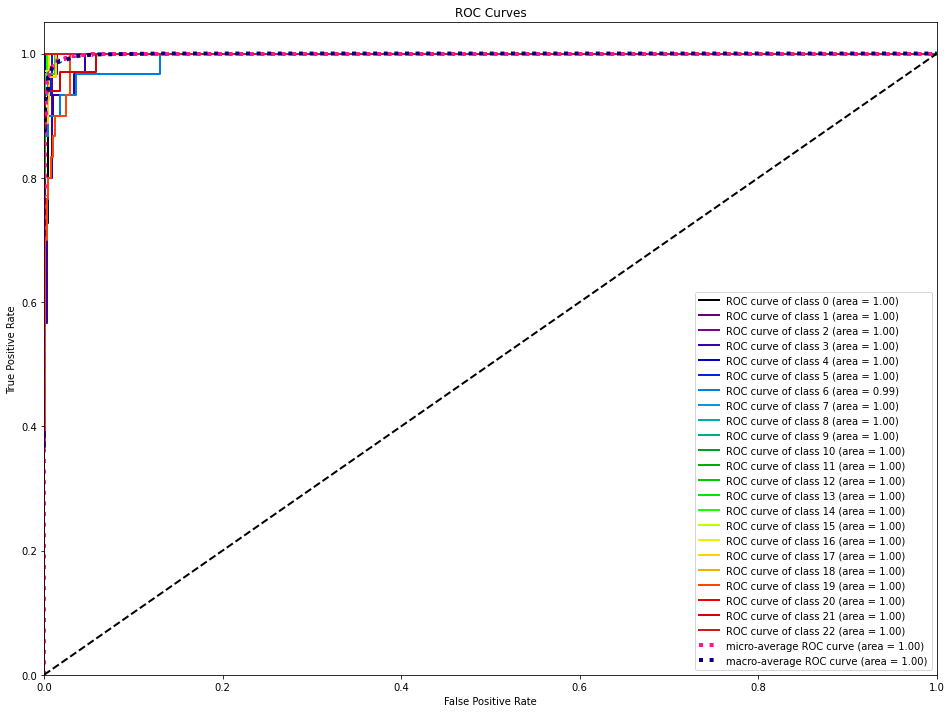

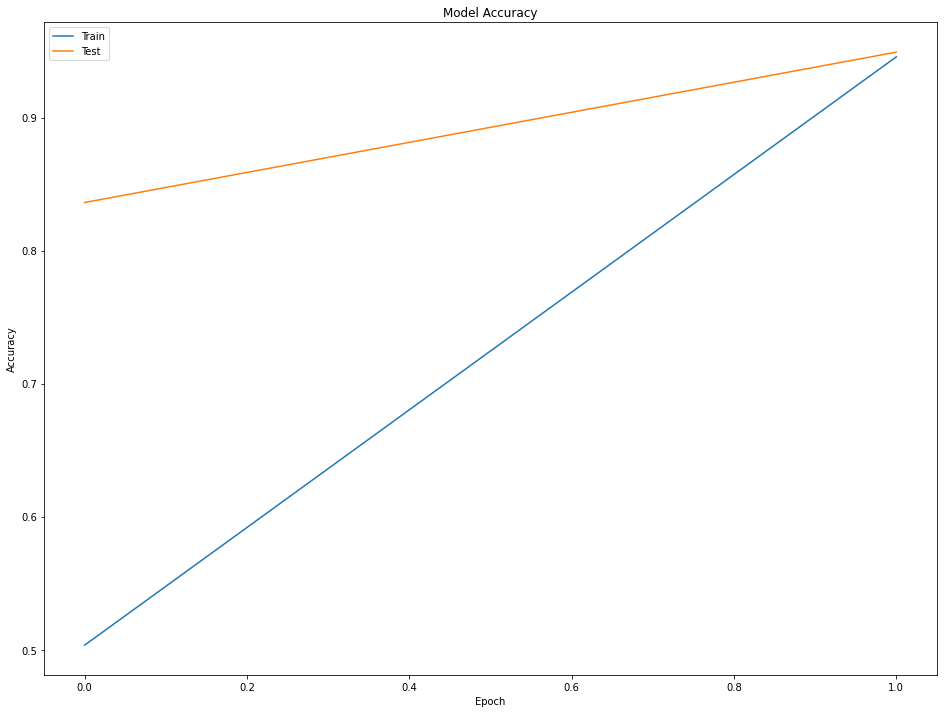

In [20]:
# Mappen von Klassen Namne auf Zahlen
class_dict = {k: v for v, k in enumerate(np.unique(train_class_name))}

# Labels der jeweiligen Bilder umwandeln
train_val    = [class_dict[train_class_name[i]] for i in range(len(train_class_name))]
train_labels = np.asarray(train_val, dtype=int)

test_val    = [class_dict[test_class_name[i]] for i in range(len(test_class_name))]
test_labels = np.asarray(test_val, dtype=int)

# print(train_val)
# print(test_val)

model = MobileNetV2(weights='imagenet')

# Testen der Predictions ohne Transfer Learning. 
# NOTE: Hier wird nur getestet (rein aus Interesse), wie das vortrainierte Netzwerk mit den Kuhbildern umgeht. In den meisten Fällen wird eine Kuh (oder ein Ox) 
#       erkannt, aber nicht immer. Witzigerweise werden einige der Bilder als Dalmatiner klassifiziert. (Auskommentieren, um Ergebnisse zu sehen!)

# predictions = model.predict(train_data)
# for decoded_predictions in decode_predictions(predictions, top=1):
#	for name, desc, score in decoded_predictions:
#		print('- {} ({:.2f}%%)'.format(desc, 100*score))

# Output Layer für die 23 Kühe anlegen
cow_output = Dense(len(class_dict), activation='softmax')
cow_output = cow_output(model.layers[-2].output)

# Neues Model aus dem Input von MobileNetV2 und dem neuen Ausgabelayer erstellen
cow_input = model.input
cow_model = Model(inputs=cow_input, outputs=cow_output)

# Alle Layer bis auf den neuen vom Training ausschließen, damit nur die Gewichte des Ausgabelayers angepasst werden
# TODO: try setting the training for the last 2 layers instead of just the last
for layer in cow_model.layers[:-1]:
	layer.trainable = False

# Kompilieren des neuen Models
cow_model.compile(
	optimizer='adam',
	loss='sparse_categorical_crossentropy',
	metrics=['accuracy']
)

performance_callback = PerformanceVisualizationCallback(
    model=cow_model,
    validation_data=(test_data, test_labels),
    image_dir='performance/'
)

# Trainieren des Models mit vorher angelegten Daten
history = cow_model.fit(x=train_data, 
              y=train_labels, 
              validation_data=(test_data, test_labels),
              callbacks=[performance_callback],
              epochs=2, 
              verbose=2)

fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')
fig.show()
fig.set_frameon(True)
fig.set_facecolor('white')
fig.savefig('performance/history.png', bbox_inches='tight', transparent=False)
